In [2]:
# load and plot dataset
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from datetime import datetime
from pandas import concat

from pandas import DataFrame
from pandas import Series

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

Month=1, Predicted=279.655147, Expected=339.700000
Month=2, Predicted=320.706731, Expected=440.400000
Month=3, Predicted=317.703354, Expected=315.900000
Month=4, Predicted=367.688026, Expected=439.300000
Month=5, Predicted=304.087546, Expected=401.300000
Month=6, Predicted=357.157743, Expected=437.400000
Month=7, Predicted=376.346610, Expected=575.500000
Month=8, Predicted=402.854862, Expected=407.600000
Month=9, Predicted=433.807486, Expected=682.000000
Month=10, Predicted=483.070235, Expected=475.300000
Month=11, Predicted=445.923668, Expected=581.300000
Month=12, Predicted=403.379067, Expected=646.900000
Test RMSE: 134.761


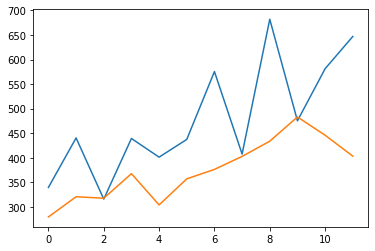

In [3]:


# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# load dataset
series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()

##Complete LSTM Example

Load the dataset from CSV file.
Transform the dataset to make it suitable for the LSTM model, including:
Transforming the data to a supervised learning problem.
Transforming the data to be stationary.
Transforming the data so that it has the scale -1 to 1.
Fitting a stateful LSTM network model to the training data.
Evaluating the static LSTM model on the test data.
Report the performance of the forecasts.
Some things to note about the example:

The scaling and inverse scaling behaviors have been moved to the functions scale() and invert_scale() for brevity.
The test data is scaled using the fit of the scaler on the training data, as is required to ensure the min/max values of the test data do not influence the model.
The order of data transforms was adjusted for convenience to first make the data stationary, then a supervised learning problem, then scaled.
Differencing was performed on the entire dataset prior to splitting into train and test sets for convenience. We could just as easily collect observations during the walk-forward validation and difference them as we go. I decided against it for readability.
The complete example is listed below.

In [4]:
# load dataset
def parser(x):
    return datetime.strptime(x, '%Y')


import csv
#players = read_csv('bsb_ref.csv', parse_dates=[4], index_col=0,squeeze=True, date_parser=parser)
players = read_csv('bsb_ref.csv', parse_dates=[4], squeeze=True, date_parser=parser)
#series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], , squeeze=True, date_parser=parser)

# summarize first few rows

#original has 
'''
print(players.shape) (107211, 48)
print(players.ndim) 2
'''

players = players.fillna(0)

# focusing on players after 1975
d1 = '1975-01-01'
date = datetime.strptime(d1, '%Y-%m-%d')

df_recent_players = players[players.year_ID >= date] #48k players
print(df_recent_players.shape) #(54579, 48)
print(df_recent_players.ndim) #2

#reorder columns so date is first
df_recent_players = df_recent_players[['year_ID', 'name_common', 'age', 'mlb_ID', 'player_ID', 'team_ID', 'stint_ID',
                                       'lg_ID', 'PA', 'G', 'Inn', 'runs_bat', 'runs_br', 'runs_dp', 'runs_field', 
                                       'runs_infield', 'runs_outfield', 'runs_catcher', 'runs_good_plays',
                                       'runs_defense', 'runs_position', 'runs_position_p', 'runs_replacement',
                                        'runs_above_rep', 'runs_above_avg', 'runs_above_avg_off', 'runs_above_avg_def',
                                       'WAA', 'WAA_off', 'WAA_def', 'WAR', 'WAR_def', 'WAR_off', 'WAR_rep',
                                       'salary', 'pitcher', 'teamRpG', 'oppRpG', 'oppRpPA_rep', 'oppRpG_rep',
                                       'pyth_exponent', 'pyth_exponent_rep', 'waa_win_perc', 'waa_win_perc_off',
                                       'waa_win_perc_def', 'waa_win_perc_rep', 'OPS_plus', 'TOB_lg', 'TB_lg']]
                                       




df_recent_players = df_recent_players.loc[df_recent_players['name_common'] == 'David Aardsma']
#df.loc[df['column_name'] == some_value]

print(df_recent_players.head())

(54579, 49)
2
     year_ID    name_common   age    mlb_ID  player_ID team_ID  stint_ID  \
0 2004-01-01  David Aardsma  22.0  430911.0  aardsda01     SFG         1   
1 2006-01-01  David Aardsma  24.0  430911.0  aardsda01     CHC         1   
2 2007-01-01  David Aardsma  25.0  430911.0  aardsda01     CHW         1   
3 2008-01-01  David Aardsma  26.0  430911.0  aardsda01     BOS         1   
4 2009-01-01  David Aardsma  27.0  430911.0  aardsda01     SEA         1   

  lg_ID   PA   G  ...  oppRpG_rep  pyth_exponent  pyth_exponent_rep  \
0    NL  0.0  11  ...     4.67092          1.890              1.890   
1    NL  3.0  43  ...     4.86457          1.912              1.913   
2    AL  0.0   2  ...     4.85895          1.912              1.912   
3    AL  1.0   5  ...     4.69650          1.893              1.894   
4    AL  0.0   3  ...     4.79788          1.905              1.905   

   waa_win_perc  waa_win_perc_off  waa_win_perc_def  waa_win_perc_rep  \
0         0.500             0

     year_ID    name_common   age    mlb_ID  player_ID team_ID  stint_ID  \
0 2004-01-01  David Aardsma  22.0  430911.0  aardsda01     SFG         1   

  lg_ID   PA   G  ...  oppRpG_rep  pyth_exponent  pyth_exponent_rep  \
0    NL  0.0  11  ...     4.67092           1.89               1.89   

   waa_win_perc  waa_win_perc_off  waa_win_perc_def  waa_win_perc_rep  \
0           0.5               0.5               0.5               0.5   

   OPS_plus  TOB_lg  TB_lg  
0       0.0     0.0    0.0  

[1 rows x 49 columns]
year_ID               datetime64[ns]
age                          float64
mlb_ID                       float64
stint_ID                     float64
PA                           float64
G                            float64
Inn                          float64
runs_bat                     float64
runs_br                      float64
runs_dp                      float64
runs_field                   float64
runs_infield                 float64
runs_outfield                flo

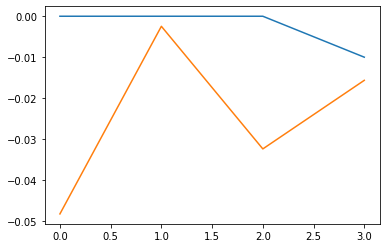

In [5]:
import numpy as np
from matplotlib import pyplot


#cast all to same type float



davidAardsmaDf = df_recent_players.head(9)
#print(davidAardsmaDf.head(0))
print(davidAardsmaDf.head(1))


davidAardsmaDf['G'] = davidAardsmaDf['G'].astype(float)
davidAardsmaDf['stint_ID'] = davidAardsmaDf['stint_ID'].astype(float)
davidAardsmaDf = davidAardsmaDf.drop(["team_ID", "lg_ID", "pitcher", "player_ID", "name_common"], axis=1)

print(davidAardsmaDf.dtypes, davidAardsmaDf)

smallDF = davidAardsmaDf
# line plot

#print(series)

# delete columns using the columns parameter of drop
#davidAardsmaDf = davidAardsmaDf.drop(columns="name_common")

# Delete multiple columns from the dataframe"
#davidAardsmaDf = davidAardsmaDf.drop(["team_ID", "lg_ID", "pitcher", "player_ID", "name_common"], axis=1)

#print(davidAardsmaDf)


smallDF = smallDF.drop(['year_ID', 'age', 'mlb_ID', 'stint_ID',
                                       'PA', 'G', 'Inn', 'runs_bat', 'runs_br', 'runs_dp', 'runs_field', 
                                       'runs_infield', 'runs_outfield', 'runs_catcher', 'runs_good_plays',
                                       'runs_defense', 'runs_position', 'runs_position_p', 'runs_replacement',
                                        'runs_above_rep', 'runs_above_avg', 'runs_above_avg_off', 'runs_above_avg_def',
                                       'WAA', 'WAA_off', 'WAA_def', 'WAR_def', 'WAR_off', 'WAR_rep',
                                       'salary', 'teamRpG', 'oppRpG', 'oppRpPA_rep', 'oppRpG_rep',
                                       'pyth_exponent', 'pyth_exponent_rep', 'waa_win_perc', 'waa_win_perc_off',
                                       'waa_win_perc_def', 'waa_win_perc_rep', 'OPS_plus', 'TOB_lg', 'TB_lg'], axis=1)

print(smallDF)
# transform data to be stationary

raw_values = smallDF.values
#s_values = series.values

oneDim = np.stack(raw_values, axis =1)
#print(raw_values)

raw_values = oneDim[0]
#print(raw_values)
diff_values = difference(raw_values, 1)


# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
print("supervised_values: ", len(supervised_values), supervised_values)
train, test = supervised_values[0:-4], supervised_values[-4:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Year=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance
rmse = sqrt(mean_squared_error(raw_values[-4:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-4:])
pyplot.plot(predictions)
pyplot.show()


In [ ]:
import numpy as np
from matplotlib import pyplot


#cast all to same type float


#print(df_recent_players.head(9))
davidAardsmaDf = df_recent_players.head(9)
#print(davidAardsmaDf.head(0))
print(davidAardsmaDf.head(1))


davidAardsmaDf['G'] = davidAardsmaDf['G'].astype(float)
davidAardsmaDf['stint_ID'] = davidAardsmaDf['stint_ID'].astype(float)
davidAardsmaDf = davidAardsmaDf.drop(["team_ID", "lg_ID", "pitcher", "player_ID", "name_common"], axis=1)

print(davidAardsmaDf.dtypes, davidAardsmaDf)

smallDF = davidAardsmaDf
# line plot

#print(series)

# delete columns using the columns parameter of drop
#davidAardsmaDf = davidAardsmaDf.drop(columns="name_common")

# Delete multiple columns from the dataframe"
#davidAardsmaDf = davidAardsmaDf.drop(["team_ID", "lg_ID", "pitcher", "player_ID", "name_common"], axis=1)

#print(davidAardsmaDf)


smallDF = smallDF.drop(['year_ID', 'age', 'mlb_ID', 'stint_ID',
                                       'PA', 'G', 'Inn', 'runs_bat', 'runs_br', 'runs_dp', 'runs_field', 
                                       'runs_infield', 'runs_outfield', 'runs_catcher', 'runs_good_plays',
                                       'runs_defense', 'runs_position', 'runs_position_p', 'runs_replacement',
                                        'runs_above_rep', 'runs_above_avg', 'runs_above_avg_off', 'runs_above_avg_def',
                                       'WAA', 'WAA_off', 'WAA_def', 'WAR_def', 'WAR_off', 'WAR_rep',
                                       'salary', 'teamRpG', 'oppRpG', 'oppRpPA_rep', 'oppRpG_rep',
                                       'pyth_exponent', 'pyth_exponent_rep', 'waa_win_perc', 'waa_win_perc_off',
                                       'waa_win_perc_def', 'waa_win_perc_rep', 'OPS_plus', 'TOB_lg', 'TB_lg'], axis=1)

print(smallDF)
# transform data to be stationary

raw_values = smallDF.values
#s_values = series.values

oneDim = np.stack(raw_values, axis =1)
#print(raw_values)

raw_values = oneDim[0]
#print(raw_values)
diff_values = difference(raw_values, 1)


# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
print("supervised_values: ", len(supervised_values), supervised_values)
train, test = supervised_values[0:-4], supervised_values[-4:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Year=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance
rmse = sqrt(mean_squared_error(raw_values[-4:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-4:])
pyplot.plot(predictions)
pyplot.show()

     year_ID    name_common   age    mlb_ID  player_ID team_ID  stint_ID  \
0 2004-01-01  David Aardsma  22.0  430911.0  aardsda01     SFG         1   

  lg_ID   PA   G  ...  oppRpG_rep  pyth_exponent  pyth_exponent_rep  \
0    NL  0.0  11  ...     4.67092           1.89               1.89   

   waa_win_perc  waa_win_perc_off  waa_win_perc_def  waa_win_perc_rep  \
0           0.5               0.5               0.5               0.5   

   OPS_plus  TOB_lg  TB_lg  
0       0.0     0.0    0.0  

[1 rows x 49 columns]
year_ID               datetime64[ns]
age                          float64
mlb_ID                       float64
stint_ID                     float64
PA                           float64
G                            float64
Inn                          float64
runs_bat                     float64
runs_br                      float64
runs_dp                      float64
runs_field                   float64
runs_infield                 float64
runs_outfield                flo